In [60]:
import numpy as np
from celmech.maps import StandardMap
import sys
sys.path.append("../code/")
from sos_utils import get_map_pts

In [61]:
smap = StandardMap(0.98)

In [62]:
pt0s = np.array([(0,x) for x in np.random.normal(0,1e-5,size=50)])

In [ ]:
smap.mod_p

In [112]:
from scipy.optimize import root_scalar

In [327]:
def symmetry_line1(s):
    return np.array((0,s))
def symmetry_line2(s):
    return np.array((np.pi,s))
def symmetry_line3(s):
    return np.array((s/2,s))
def nest_map(pt0,smap,n):
    for _ in range(n):
        pt0 = smap(pt0)
    return pt0

def nest_map_list(pt0,smap,n):
    pts = np.zeros((n,2))
    for i in range(n):
        pts[i] = pt0
        pt0 = smap(pt0)
    return pts
    
def find_periodic_orbit(m,n,smap,guess=None,minimax=False):
    
    smap.mod_p = False
    smap.mod_theta = False

    if minimax:
        symline = symmetry_line1
    else:
        symline = symmetry_line2 if n%2 else symmetry_line3
    rootfn = lambda s: nest_map(symline(s),smap,n)[0] - symline(s)[0] - 2 * np.pi * m
    if guess is None:
        guess = 2 * m * np.pi / n
    xmin = 2 * (m-1) * np.pi / n
    x0  = 2 * m * np.pi / n
    xmax = 2 * (m+1) * np.pi / n
    
    bracket = [xmin + 0.5*(guess -xmin),guess]
    rt = root_scalar(rootfn,x0=guess,x1 = bracket[0])
    pt0 = symline(rt.root)    
    orbit = nest_map_list(pt0,smap,n)
    
    return orbit
def get_H_matrix(orbit,smap):
    N = len(orbit)
    off_diag = np.ones(N-1)
    H = 2 * np.eye(N) - np.diag(off_diag,-1) - np.diag(off_diag,+1)
    thetas = orbit[:,0]
    H = H + smap.K * np.diag(np.cos(thetas))
    H[N-1,0]=-1
    H[0,N-1]=-1
    return H
def get_M_matrix(orbit,smap):
    M = np.eye(2)
    for pt in orbit:
        M = np.matmul(smap.jac(pt) , M)
    return M

In [175]:
import sympy as sp
from sympy.ntheory import continued_fraction, continued_fraction_convergents

(3.3, 3.4)

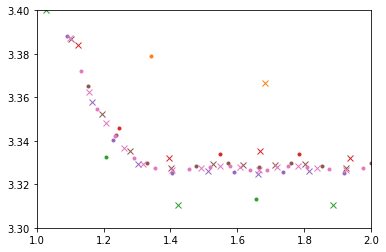

In [338]:
sp.continued_fraction(phi)
cf = continued_fraction_convergents([0] + [1 for _ in range(10)])
convergents = [(f.numerator,f.denominator) for f in cf][4:]

smap.K = 0.97

Rvals = np.zeros((len(convergents),2))
Rvals_Mmethod = np.zeros((len(convergents),2))
fvals = np.zeros((len(convergents),2))

wrap2pi = lambda x: np.mod(x,2*np.pi)
for i,convergent in enumerate(convergents):
    
    m,n = convergent
    
    minimax_orbit = find_periodic_orbit(m,n,smap,minimax=True)
    minimizing_orbit = find_periodic_orbit(m,n,smap)

    theta,p = np.transpose(minimax_orbit)
    theta = wrap2pi(theta)
    l,=plt.plot(theta,p,'.')

    theta,p = np.transpose(minimizing_orbit)
    theta = wrap2pi(theta)
    plt.plot(theta,p,'x',color=l.get_color())
    
    
    Hmtrx = get_H_matrix(minimax_orbit,smap)
    Mmtrx = get_M_matrix(minimax_orbit,smap)
    Rvals[i,0] = -0.25 * np.linalg.det(Hmtrx)
    Rvals_Mmethod[i,0] = 0.25 * (2 - np.trace(Mmtrx))
    fvals[i,0] = (np.abs(Rvals[i,0])/0.25)**(1/n)
    
    Hmtrx = get_H_matrix(minimizing_orbit,smap)
    Mmtrx = get_M_matrix(minimizing_orbit,smap)
    Rvals_Mmethod[i,1] = 0.25 * (2 - np.trace(Mmtrx))
    Rvals[i,1] = -0.25 * np.linalg.det(Hmtrx)
    fvals[i,1] = (np.abs(Rvals[i,1])/0.25)**(1/n)
plt.xlim(1,2)
plt.ylim(3.3,3.4)